In [86]:
import GPy
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
df = pd.read_pickle('Random_GMRQ-2_GMRQ-CSE-clean.pickl')


In [19]:
df.head(2)

,id,feature,parameters,test_scores,train_scores,cse_test_scores,cse_train_gaps,cse_train_n_timescales,cse_train_scores,test_scores_mean,cse_test_scores_mean,cse_train_gaps_mean
947,2,alpha_angle,"{'msm__lag_time': 50, 'cluster__max_no_improve...","[2.7929254738960707, 2.806366141062694, 2.6499...","[2.8238005249605154, 2.870721463825274, 2.9884...","[1.96372272307, 1.99871800747, 1.98917327543, ...","[3.97634298203, 16.9731128258, 42.2860267941, ...","[1, 1, 1, 1, 2]","[1.99048647384, 1.99925393958, 1.99986176834, ...",2.613855,2.185815,16.218150
76,4,alpha_angle,"{'msm__lag_time': 50, 'cluster__max_no_improve...","[2.948540113694251, 2.632606230422432, 2.87014...","[2.993834214901289, 2.978360161399329, 2.99909...","[5.40378045921, 3.88709659215, 1.95245287852, ...","[2.89773741805, 6.58039903006, 17.0715041883, ...","[5, 3, 1, 2, 1]","[5.86174757165, 3.9922788621, 1.99992166853, 2...",2.878763,3.207427,55.256862


In [31]:
# extract params
params = ['tica__lag_time', 'tica__n_components', 'cluster__n_clusters']
for param in params:
    df[param.split('__')[-1]] = df['parameters'].apply(lambda x: x[param])

In [35]:
# calculate error
df['test_error'] = df['test_scores'].apply(lambda x: np.array(x).std())

In [27]:
feature='kappa_angle'

In [146]:
# Get obvservations
y = df.loc[df['feature']==feature, 'test_scores_mean'].values

In [147]:
# Get inputs:
X = df.loc[df['feature']==feature, ['lag_time','n_components', 'n_clusters']].values

In [148]:
X.T[0] = np.log(X.T[0]+10)


In [149]:
# Get noise
err = df.loc[df['feature']==feature, 'test_error'].values

In [150]:
y = y[:, None]
# X = X[:, None]
err = err[:, None]
print(y.shape, X.shape, err.shape)


(199, 1) (199, 3) (199, 1)


In [151]:
# Test/training split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, err_train, err_test = train_test_split(X, y, err, test_size=0.4, random_state=42)

## Homoscedastic GP regresssion

### The kernels

In [152]:
noise = GPy.kern.White(input_dim=3)
kernels = [GPy.kern.RBF(input_dim=3, ARD=True) + noise, 
          np.product([GPy.kern.RBF(input_dim=1, active_dims=[i]) for i in range(X.shape[1])]) + noise, 
          np.sum([GPy.kern.RBF(input_dim=1, active_dims=[i]) for i in range(X.shape[1])]) + noise, 
          GPy.kern.Matern52(input_dim=3, ARD=True) + noise, 
          np.product([GPy.kern.Matern52(input_dim=1, active_dims=[i]) for i in range(X.shape[1])]) + noise, 
          np.sum([GPy.kern.Matern52(input_dim=1, active_dims=[i]) for i in range(X.shape[1])]) + noise]

### Optimize the models

In [153]:
smses = []
models = []
mslls = []
for kern in kernels:
    m = GPy.models.GPRegression(X_train,y_train,kern)
    m.optimize_restarts(num_restarts = 20, verbose=False)
    smse = np.mean((y_test - m.predict(X_test, kern=None)[0])**2)/y_test.var()
    smses.append(smse)
    msll = np.mean(-m.log_predictive_density(X_test, y_test))
    mslls.append(msll)
    models.append(m)

    

 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:158: RuntimeWarning:overflow encountered in true_divide
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:129: RuntimeWarning:overflow encountered in square
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:130: RuntimeWarning:invalid value encountered in add
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/paramz-0.7.4-py3.5.egg/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/paramz-0.7.4-py3.5.egg/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in true_divide
 /Users/robert_arbon/anaconda/envs/ml4dyn/li

LinAlgError: not positive definite, even with jitter.

<Container object of 6 artists>

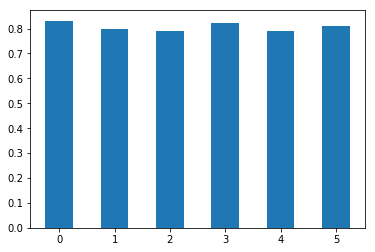

In [109]:
plt.bar(np.arange(len(smses)), smses, width=0.5)

<Container object of 6 artists>

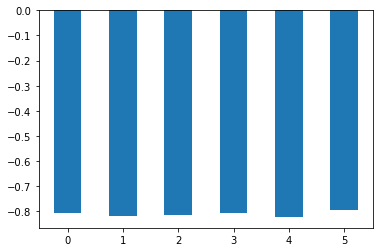

In [110]:
plt.bar(np.arange(len(mslls)), mslls, width=0.5)

In [115]:
idx_err = np.argmin(smses)
idx_err 

4

In [118]:
idx_mll = np.argmin(mslls)
idx_mll

4

In [122]:
models[idx_mll]


GP_regression.,value,constraints,priors
sum.mul.Mat52.variance,6.37197417829e-06,+ve,
sum.mul.Mat52.lengthscale,1583198.58764,+ve,
sum.mul.Mat52_1.variance,417.866208614,+ve,
sum.mul.Mat52_1.lengthscale,35.8838140812,+ve,
sum.mul.Mat52_2.variance,1508.87320781,+ve,
sum.mul.Mat52_2.lengthscale,1335783.01028,+ve,
sum.white.variance,0.00465758441118,+ve,
Gaussian_noise.variance,0.00434060543459,+ve,
